# 06. PyTorch Transfer Learning

What is transfer learning?

Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation models

In [1]:
import torch
import torchvision


torch.__version__, torchvision.__version__

('1.13.0+cu117', '0.14.0+cu117')

In [2]:
# Setup device-agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
!nvidia-smi

Sun Jul 16 20:19:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.40                 Driver Version: 536.40       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P0              27W /  95W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [4]:
import os
import zipfile
import requests
from pathlib import Path


# Setup data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f'{image_path} exists, skipping re-creating.')
else:
    print(f'{image_path} does not exist, create it')
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(image_path / 'pizza_steak_sushi.zip', 'wb') as f:
        request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as f:
        print('Unzipping pizza, steak, sushi data...')
        f.extractall(image_path)

    # Remove zip file
    os.remove(image_path / 'pizza_steak_sushi.zip')

data\pizza_steak_sushi exists, skipping re-creating.


In [5]:
# Setup directories path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we're get some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular.

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:
1. Manually created transforms.
   1. You define what transforms you want to your data to go through.
2. Automatically created transforms.
   1. The transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning ) right within `torchvision`.


> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].You can use the following transform to normalize:


In [6]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229, .224, .225])


manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    normalize])  # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)

In [7]:
from going_modular import data_setup


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transforms, batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ddfbd0ed70>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights you're using.

In [8]:
# Get a set of pretrained model weight
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # "Default" = best performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
# Create DataLoaders using automatic transform
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=auto_transforms, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1ddfbd0f970>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty of different models)
4. Paperwithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it need to run?
2. Size - how big the model?
3. Performance - how well does it go on your chosen problem (e.g. how well does it classify food images? for FoodVision Mini)

Where does the model live?

Is it on device? (like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/stable/models.html#classification

Which model should we chose?

For our case (deploying FoodVision Mini on a mobile device), it looks like EffNetB0 is one of our best options in terms performance vs size.

However, in light of [The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html), if we had infinite compute, we'd likely pick the biggest model + most paramters + most general we could

### 3.2 Setting up a pretrained model

Want to create an instance of a pretrained [EffNetB0](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights)

In [12]:
# OLD method creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True) 

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [13]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [14]:
# Print with torchinfo
from torchinfo import summary


summary(model=model,
        input_size=(1, 3, 224, 224),  # example of [batch, channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit for needs

With a feature extrator model, typically you will 'freeze' the base layers of a pretrained/foundation model and update the output lyyers to suit your own problem.

In [24]:
# Freeze all of the base layers in EffNet0
for param in model.features.parameters():
    param.requires_grad = False

In [28]:
# Update the classifier head of our model to suit our problem
from torch import nn


torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=.2, inplace=True),
    nn.Linear(in_features=1280,  # feature vector coming in
              out_features=len(class_names)).to(device)  # how many classes we have?
)

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [29]:
summary(model=model,
        input_size=(1, 3, 224, 224),  # example of [batch, channels, height, width]
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [31]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=.001)

In [32]:
# Import train function
from going_modular import engine

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer
end_time = timer()
print(f'[INFO] Total training time: {end_time - start_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9132 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7108 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6254 | train_acc: 0.7852 | test_loss: 0.6260 | test_acc: 0.8561
[INFO] Total training time: 10.630 seconds


## 5. Evaluate model by plotting loss curve

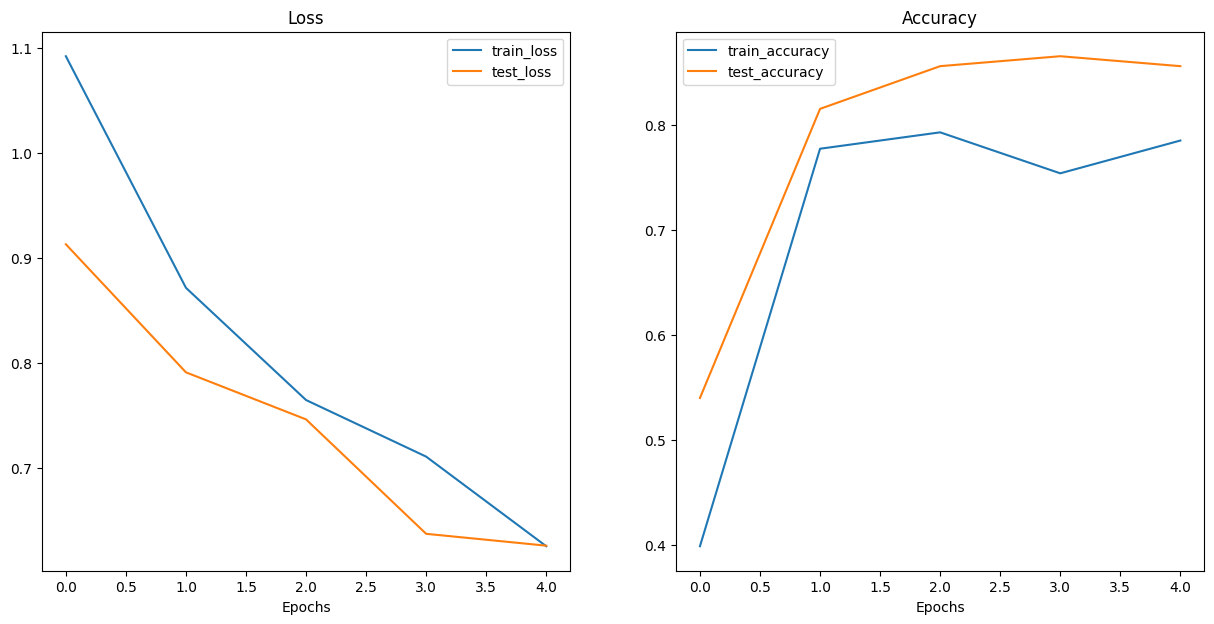

In [33]:
try:
    from helper_function import plot_loss_curves
except:
    print(f"[INFO] Couldn't find helper_function.py, download...")
    with open('helper_function.py', 'w') as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_function import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results=results)

What do our loss curve look like in terms of the ideal loss curve?

See here - https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

## 6. Make prediction on images from test set

Let's adhere to the data explorer's motto of *Visualize, visualize, visualize*!

And make some quanlitative prediction on our test set.

Some things to keep in mind when making prediction/inference on test data/custom data.

We have to make sure that our test/custom data is:
* Same shape - images needs to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you're transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automatically, let's create a function called `pred_and_plot_image()`:
The function will be similar to the one [here](https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function)

1. Taking a trained model, a list of class name, a filepath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.open()`
3. Create a transform of one doesn't exist
4. Make sure the model is on the target device
5. Turn the model into `model.eval()` mode to make sure it's ready for inference (this will turn off things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size) 
7. Make a prediction on the image by passing to the model
8. Convert the model's output logits to prediction probabilities using `torch.softmax()`
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probabilities from step 8.

In [42]:
import matplotlib.pyplot as plt
from typing import List, Tuple
from PIL import Image
from torchvision import transforms


# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int]=(224, 224),
                        transform: torchvision.transforms=None,
                        device: torch.device=device):
    # 2. Open the image with PIL
    img = Image.open(image_path)

    # 3. Create a transform if one doesn't exist
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(size=image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[.485, .456, .406],
                                 std=[.229, .224, .225])
        ])

    ### Predict on image ###
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on inference mode and eval mode
    with torch.inference_mode():
        model.eval()
        # 6. Transform the image and add an extra batch dimension
        transformed_image = image_transform(img).unsqueeze(dim=0)  # [batch_size, color_channel, height, width]

        # 7. Make a prediciton on a transformed image by passing it to the model (also ensure it's on the target device)
        target_image_pred = model(transformed_image.to(device))

    # 8. Convert the model's output logits to pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert the model's pred probs to pred labels
    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max():.3f}')
    plt.axis('off')

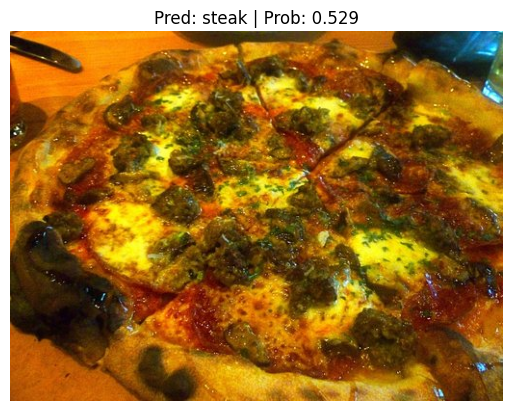

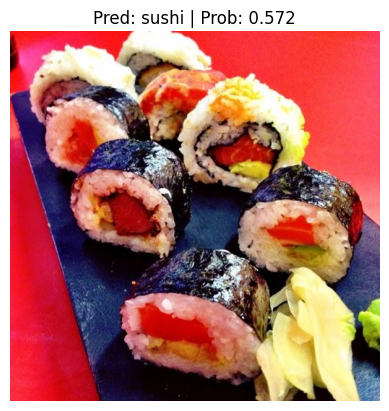

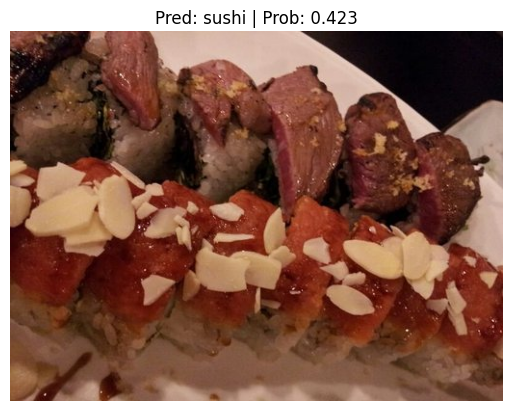

In [44]:
# Get a random list of image paths from the test set
import random


num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make prediction on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))